In [69]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import deepcopy

from model import Model
import utils
from early_stopping import EarlyStopping
from priors import moving_average
from sklearn.decomposition import PCA

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
config = utils.read_config()
# set seeds
# utils.set_seeds(config['seed'])
utils.set_seeds(42)

In [72]:
behaviour_data, spikes, trial_ids = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data, spikes = [x[time_from:, :] for x in behaviour_data], [x[time_from:, :] for x in spikes]

In [73]:
stim_idx, choice_idx, amp_idx = 9, 3, 24
stim = [x[0, stim_idx] for x in behaviour_data]
choice = [x[0, choice_idx] for x in behaviour_data]
amp = [x[:, amp_idx] for x in behaviour_data]
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)

In [74]:
# convert to torch tensors
behaviour_data = torch.tensor(behaviour_data, dtype=torch.long)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = torch.tensor(spikes, dtype=torch.float32)
# subset of neurons
chosen = [2, 4, 6, 8, 11, 12, 14, 15, 16, 30, 33]
spikes = spikes[:, :, chosen]
num_trials, time_bins, emissions_dim = np.array(spikes).shape

In [75]:
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.2, random_state=7)

# create dataloaders
train_dataset = TensorDataset(behaviour_data_train, spikes_train)
test_dataset = TensorDataset(behaviour_data_test, spikes_test)

batch_size = config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [76]:
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0].numpy()), np.mean(behaviour_data_train[:, 1].numpy())))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0].numpy()), np.mean(behaviour_data_test[:, 1].numpy())))

Train distribution of Stimulus: 0.46875, Choice: 0.359375
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486


In [77]:
# mean firing rate of neurons in tran spikes
neuron_bias = torch.mean(spikes_train, dim=0)

In [78]:
# # check if mps is available
# device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
# print(device)
# model = model.to(device)
# spikes = spikes.to(device)

In [79]:
def test(model, test_loader, n_samples):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
            vae_pred, behavior_pred = model(spikes_batch, n_samples=n_samples)
            # calculate loss
            loss, loss_l = model.loss(np.inf, spikes_batch, behavior_batch, vae_pred, behavior_pred)
            # l.append(loss_l[1])
            test_loss += np.array(loss_l)            
            # print(np.mean(l), np.std(l))
    # divide loss by total number of samples in dataloader    
    return test_loss/len(test_loader)

In [80]:
config = utils.read_config()
# create model and optimizer
model = Model(config, input_dim=emissions_dim)
# model = Model(config, input_dim=emissions_dim, neuron_bias=neuron_bias)
# model = torch.compile(model)
early_stop = EarlyStopping(patience=config['early_stop']['patience'], delta=config['early_stop']['delta'], trace_func=print)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=1, verbose=True, patience=5, factor=0.5)
# print named parameters of model
# print("Model's state_dict:")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)
print(model.arch_name)

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 408
Number of trainable parameters in Posterior Mean: 54
Number of trainable parameters in Block Diagonal Z: 27
Number of trainable parameters in Cov X: 81
Number of trainable parameters in VAE: 663
Using stimulus decoder
Using choice decoder
Scheduler not implemented for decoder
Number of trainable parameters in behavior decoder: 68
vae_gp_[1, 1, 1]_diagonal_gru_4_1_True_noise_0.01_rbfscale_0.5_smoothing_3_monotonic_1_1_10_[True, True, False]_3_entropy_Nonecnn_4_5


In [81]:
# train the model
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses = [], []

def train(model: Model, train_loader, val_loader, early_stop):    
    test_every = config['test_every']    
    train_decoder_after = config['decoder']['train_decoder_after']    
    num_samples_train = config['num_samples_train']
    optim_size = config['optim_size']
    save_model = True    
    for epoch in range(config['epochs']):
        # forward pass
        # print(model.behavior_decoder.scheduler.get_last_lr())
        # model.vae.scheduler.get_last_lr()
        epoch_loss = 0
        model.train()
        model.optim_zero_grad()
        optim_counter = 0
        for i, (behavior_batch, spikes_batch) in enumerate(train_loader):            
            # behavior_batch = behavior_batch.long()
            vae_pred, behavior_pred = model(spikes_batch, n_samples=num_samples_train)
            optim_counter += len(behavior_batch)
            # calculate loss
            loss, loss_l = model.loss(epoch, spikes_batch, behavior_batch, vae_pred, behavior_pred)
            epoch_loss += np.array(loss_l)            
            # backward pass            
            loss.backward()
            
            # print gradient of any weight
            # if epoch > 10:
            #     print(model.behavior_decoder.conv_choice[1].weight.grad)
            if optim_counter >= optim_size:
                model.optim_step(train_decoder = epoch >= train_decoder_after)
                model.optim_zero_grad()
                print("Stepping inside")
                optim_counter = 0
        # do it for the rest        
        model.optim_step(train_decoder = epoch >= train_decoder_after)
        model.optim_zero_grad()
        
        # if epoch % 100 == 0:
        #     # print lr of decoder
        #     print(model.behavior_decoder.scheduler.get_last_lr())
        train_losses.append((epoch, epoch_loss/len(train_loader)))
        model.scheduler_step(step_decoder = epoch >= train_decoder_after)
        # test loss
        if (epoch+1) % test_every == 0:
            test_loss = test(model, val_loader, n_samples=config['num_samples_test'])
            sum_test_loss = np.sum(test_loss)
            # scheduler.step(sum_test_loss)
            test_losses.append((epoch, test_loss))
            early_stop(sum_test_loss, model, save_model=save_model, save_prefix='best')
            model.save_model(save_prefix=str(epoch))
            print('Epoch [{}/{}], Train Loss: {}, Test Loss: {}, Best Loss: {}'.format(epoch+1, config['epochs'], train_losses[-1][1], test_losses[-1][1], early_stop.best_score))
            if early_stop.slow_down:
                test_every = config['early_stop']['test_every_new']
            else:
                test_every = config['test_every']
            if early_stop.early_stop:
                print("Early stopping")
                break
            
    
    only_test_loss = [np.sum(x[1]) for x in test_losses]
    
    # compute min test loss and return it    
    # return np.min(only_test_loss), train_losses, test_losses
    
    # compute median of test loss in a window of 5
    meds = []
    half_window = 10
    only_test_loss = [0]*(half_window) + only_test_loss + [0]*(half_window)
    for i in range(half_window, len(only_test_loss)-half_window):
        meds.append(np.max(only_test_loss[i-half_window:i+half_window]))
    return np.min(meds), train_losses, test_losses

_ = train(model, train_loader, test_loader, early_stop)
# train model
# min_test_loss, train_losses, test_losses = train(model, test_loader)

Epoch [20/2000], Train Loss: [943.92498779  24.41687965], Test Loss: [942.60144043  24.7779808 ], Best Loss: 967.3794212341309
Saved best
Epoch [40/2000], Train Loss: [924.39025879  24.10048103], Test Loss: [926.08581543  24.45409393], Best Loss: 950.539909362793
Saved best
Epoch [60/2000], Train Loss: [910.38916016  23.89078712], Test Loss: [912.79827881  24.55224037], Best Loss: 937.3505191802979
Saved best
Epoch [80/2000], Train Loss: [901.85998535  23.66722107], Test Loss: [904.02783203  24.68756485], Best Loss: 928.7153968811035
Saved best
Epoch [100/2000], Train Loss: [894.95721436  23.44851685], Test Loss: [897.23303223  24.55553055], Best Loss: 921.7885627746582
Saved best
Epoch [120/2000], Train Loss: [889.14111328  23.16617775], Test Loss: [891.61114502  24.82169533], Best Loss: 916.43284034729
Saved best
Epoch [140/2000], Train Loss: [883.99279785  22.90324783], Test Loss: [886.49963379  25.1626339 ], Best Loss: 911.6622676849365
Saved best
Epoch [160/2000], Train Loss: [879

KeyboardInterrupt: 

In [ ]:
train_losses_og, test_losses_og = train_losses[:], test_losses[:]

In [ ]:
# model.prior_modules[0].plot_gaussian()
# model.prior_modules[0].log_std

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


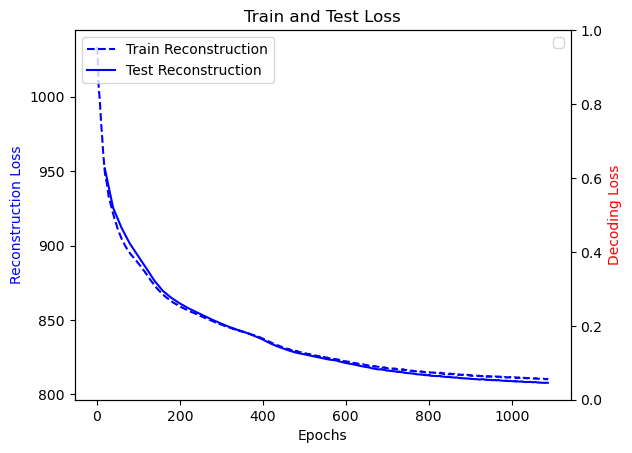

In [15]:
utils.plot_curve(model, config, train_losses, test_losses)

In [ ]:
# sort list by test loss
sorted_loss = sorted(test_losses, key=lambda x: x[1][1], reverse=True) 
# extract first element after epoch 600
sorted_loss = [(x[0], x[1][1]/100) for x in sorted_loss if x[0] > 100]
print(sorted_loss[:2], sorted_loss[-10:])
# print(test_losses)

In [ ]:
# load best model
model.load_model('best')
# model.load_model(save_prefix='best', base_path='/Users/mithileshvaidya/Code/VAE/revised/results/dandi_sub-221CR_ses-20190515T160400/100_ms/3monotonicitybest_vae_gp_[1, 1, 1]_diagonal_gru_8_2_True_noise_0.01_rbfscale_0.5_smoothing_3_monotonic_1_1_20_[True, True, False]_3_entropy_None')
# load model from epoch x
# model.load_model('219')

In [ ]:
lin_maps = model.vae.linear_maps
# c1, c2 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy()
# print(c1.T.dot(c2)/(np.linalg.norm(c1)*np.linalg.norm(c2)))
c1, c2, c3 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy(), lin_maps[2].weight.detach().numpy()
b1, b2, b3 = lin_maps[0].bias.detach().numpy(), lin_maps[1].bias.detach().numpy(), lin_maps[2].bias.detach().numpy()
with open('subspaces_filtered.pkl', 'wb') as f:
    pickle.dump([c1, c2, c3, b1, b2, b3], f)
# find cosine similarity of all pairs
# print(c1.T.dot(c2)/(np.linalg.norm(c1)*np.linalg.norm(c2)), c1.T.dot(c3)/(np.linalg.norm(c1)*np.linalg.norm(c3)), c2.T.dot(c3)/(np.linalg.norm(c2)*np.linalg.norm(c3)))

In [85]:
colors = ['red', 'blue', 'green', 'yellow', 'black', 'pink']
# convert to numpy
spikes_train_np = spikes_train.detach().numpy()
spikes_test_np = spikes_test.detach().numpy()
spikes_np = spikes.detach().numpy()

with torch.no_grad():
    model.eval()        
    # run on only test
    vae_output, _ = model.forward(spikes_test, n_samples=1)  
    y_recon_test, x_mu_test, z_mu_test, x_A_test, z_A_test, x_test, z_test, z_test_presoftmax, g_test = model.vae.extract_relevant(vae_output)
    # run only on train
    vae_output, _ = model.forward(spikes_train, n_samples=1)
    y_recon_train, x_mu_train, z_mu_train, x_A_train, z_A_train, x_train, z_train, z_train_presoftmax, g_train = model.vae.extract_relevant(vae_output)
    # run on both
    vae_output, _ = model.forward(spikes, n_samples=1)
    y_recon_all, x_mu_all, z_mu_all, x_A_all, z_A_all, x_all, z_all, z_presoftmax_all, g_all = model.vae.extract_relevant(vae_output)

# compute bits/spike
bits_per_spike_train = utils.bits_per_spike(y_recon_train, spikes_train_np)
bits_per_spike_test = utils.bits_per_spike(y_recon_test, spikes_test_np)
bits_per_spike = utils.bits_per_spike(y_recon_all, spikes_np)
# # show distribution of bits per spike
# plt.hist(bits_per_spike_train, bins=50)
# plt.xlabel('Bits/spike')
# plt.ylabel('Frequency')
# plt.show()
# print('Bits per spike: {}'.format(bits_per_spike))
print("Bits per spike train: {}, test: {}, all: {}".format(np.sum(bits_per_spike_train), np.sum(bits_per_spike_test), np.sum(bits_per_spike)))

to_write = (y_recon_train, x_mu_train, z_mu_train, x_A_train, z_A_train, x_train, z_train, z_train_presoftmax, g_train,
            y_recon_test, x_mu_test, z_mu_test, x_A_test, z_A_test, x_test, z_test, z_test_presoftmax, g_test)
pth = os.path.join(utils.model_store_path(config, model.arch_name), 'res.pkl')
with open(pth, 'wb') as f:
    pickle.dump(to_write, f)
# print(pth)

Bits per spike train: 0.4007391035556793, test: 0.37701502442359924, all: 0.399812787771225


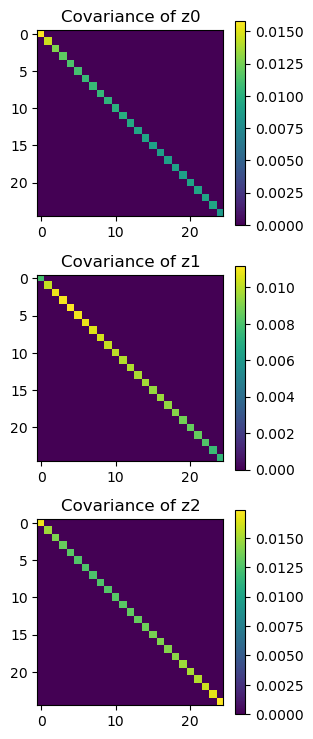

In [34]:
# cov = np.mean(z_A_train, axis=0)[10, :, :]
# print(cov)
# plt.imshow(np.linalg.inv(cov))
fig, ax = plt.subplots(3, 1, figsize=(3, 9))
for i in range(3):
    cov = np.mean(z_A_train, axis=0)[:, :, i]    
    im = ax[i].imshow(cov)
    ax[i].set_title("Covariance of z{}".format(i))
    plt.colorbar(im, ax=ax[i])
plt.show()

In [ ]:
# plot PSTH of reconstructed and original data
averaged_recon, averaged_original = y_recon.mean(axis=0), spikes_np.mean(axis=0)
# stimulus and choice important
common = [12, 14, 4, 31]
stim_neurons = [15, 11, 33, 30]
choice_neurons = [16, 2, 6, 8]
# plot each in a 5x7 grid
fig, axs = plt.subplots(5, 7, figsize=(12, 9))
# set title of figure
fig.suptitle('yellow: choice, green: stimulus, pink: common')
for i in range(5):
    for j in range(7):
        neuron_idx = i*7+j        
        axs[i, j].plot(averaged_recon[:, neuron_idx], label='recon', color='red')
        axs[i, j].plot(averaged_original[:, neuron_idx], label='original', color='blue')
        # no ticks
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # set title of plot to neuron index
        # print only 2 decimal places        
        axs[i, j].set_title('{}: {:.4f}'.format(neuron_idx, bits_per_spike_all[neuron_idx]))
        # set background color of plot to green if neuron in choice
        if neuron_idx in choice_neurons:
            axs[i, j].set_facecolor('yellow')
        # set background color of plot to red if neuron in stimulus
        if neuron_idx in stim_neurons:
            axs[i, j].set_facecolor('green')
        # set background color of plot to blue if neuron in common
        if neuron_idx in common:
            axs[i, j].set_facecolor('pink')
axs[0, 0].legend()

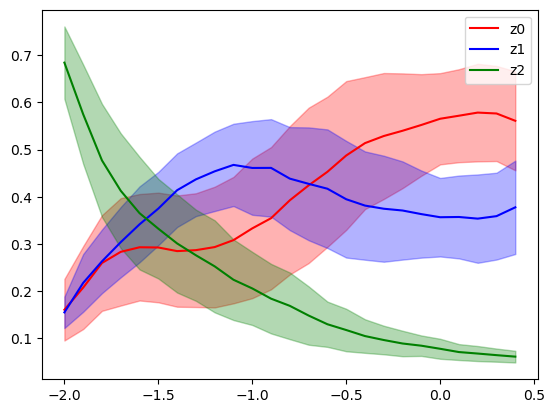

In [86]:
# plot trial averaged latent space
# z, x = torch.nn.Softmax(dim=2)(mu[:, :, :model.vae.z_dim]).numpy(), mu[:, :, model.vae.z_dim:].numpy()
z = z_all
# z = z_mu_all
# z = z_all_presoftmax
# x = x_all
x = x_mu_all
z_std = np.std(z, axis=0)
z_avg = np.mean(z, axis=0)
# make x ticks of range 0.1 from -2 to 0.5
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
for i in range(z.shape[2]):
    plt.plot(t, z_avg[:, i], label='z{}'.format(i), color=colors[i])    
    plt.fill_between(t, z_avg[:, i]-z_std[:, i], z_avg[:, i]+z_std[:, i], alpha=0.3, color=colors[i])
# plt.set_title('z')
plt.legend()

In [ ]:
def plot_cont_latent(data, label, ax_id, linestyle):
    num_latents = data.shape[1]
    for i in range(num_latents):
        axs[ax_id].plot(t, data[:, i], label='{}_x{}'.format(label, i),
                        color=colors[i], linestyle=linestyle)    
    
# behave_data, x_data = behaviour_data_train, x_train
behave_data, x_data = behaviour_data_test, x_test
# behave_data, x_data = behaviour_data, x
# group x for stimulus and choice
stim, choice = behave_data[:, 0].numpy(), behave_data[:, 1].numpy()
# group x for stimulus
x_stim_left, x_stim_right = x_data[stim == 1].mean(axis=0), x_data[stim == 0].mean(axis=0)
x_choice_left, x_choice_right = x_data[choice == 1].mean(axis=0), x_data[choice == 0].mean(axis=0)
# plot x for stimulus and choice
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_cont_latent(x_stim_left, 'stim left', 0, '-')
plot_cont_latent(x_stim_right, 'stim right', 0, '-.')
axs[0].set_title('x grouped by stimulus')
axs[0].legend()

plot_cont_latent(x_choice_left, 'choice left', 1, '-')
plot_cont_latent(x_choice_right, 'choice right', 1, '-.')
axs[1].set_title('x grouped by choice')
axs[1].legend()


In [ ]:
# plot x on 2d
choice = behaviour_data[:, 1].numpy()
# group x for stimulus
x_choice_left, x_choice_right = x[choice == 1].mean(axis=0), x[choice == 0].mean(axis=0)
z_choice_left, z_choice_right = z[choice == 1].mean(axis=0), z[choice == 0].mean(axis=0)
# plot first 2 dimensions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_choice_left[:, 0], x_choice_left[:, 1], label='choice left', color='red')
ax.plot(x_choice_right[:, 0], x_choice_right[:, 1], label='choice right', color='blue')
# mark starting point
ax.scatter(x_choice_left[0, 0], x_choice_left[0, 1], color='red')
ax.scatter(x_choice_right[0, 0], x_choice_right[0, 1], color='blue')
ax.legend()
ax.set_title('x grouped by choice')

In [ ]:
import decoder
nsamps = config['num_samples_train']
with torch.no_grad():
    model.eval()    
    _, mu_train, A_train, z_train_all, x_train_all, _ = model.forward(spikes_train, n_samples=nsamps)
    _, mu_test, A_test, z_test_all, x_test_all, _ = model.forward(spikes_test, n_samples=nsamps)

z_train, x_train = z_train_all[:, :, 2:], x_train_all[:, :, 2:]
z_test, x_test = z_test_all[:, :, 2:], x_test_all[:, :, 2:]
# train the linear decoder for behavior
# create linear decoder
linear_decoder = decoder.CNNDecoderIndividual(config, [0, 1, 0])
decoder_train_l, decoder_test_l = [], []
for epoch in range(100):    
    # forward pass        
    linear_decoder.train()
    behavior_pred = linear_decoder(x_train, z_train)
    # print(behavior_pred)
    # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    # print(behavior_pred.shape, behaviour_data_train.shape)
    loss = linear_decoder.loss(behavior_pred, behaviour_data_train, None)
    # backward pass
    linear_decoder.optimizer.zero_grad()
    loss.backward()
    linear_decoder.optimizer.step()
    epoch_loss = loss.item()    
    decoder_train_l.append(epoch_loss)
    # test loss
    if (epoch+1) % 1 == 0:
        linear_decoder.eval()
        test_pred = linear_decoder(x_test, z_test)
        # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
        test_loss = linear_decoder.loss(test_pred, behaviour_data_test, None).item()        
        decoder_test_l.append(test_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, decoder_train_l[-1], decoder_test_l[-1]))
    
with torch.no_grad():
    behavior_pred_train = linear_decoder(x_train, z_train).detach()
    behavior_pred_test = linear_decoder(x_test, z_test).detach()
    # behavior_pred_train = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    # behavior_pred_test = linear_decoder(mu_test[:, :, :2], mu_test[:, :, 2:])

In [87]:
num_samples = 100
agg_pred_train, agg_pred_test = [], []
agg_y_train, agg_y_test = [], []

# convert to numpy
y_train = behaviour_data_train.numpy()
y_test = behaviour_data_test.numpy()
# accuracy of stimulus and choice
acc_stim_train, acc_stim_test = [], []
acc_choice_train, acc_choice_test = [], []

with torch.no_grad():
    model.eval()
    behavior_pred_train_all = model.forward(spikes_train, n_samples=num_samples)[1]
    behavior_pred_test_all = model.forward(spikes_test, n_samples=num_samples)[1]
    for k in range(num_samples):
        b1 = behavior_pred_train_all.shape[0]//num_samples
        b2 = behavior_pred_test_all.shape[0]//num_samples
        behavior_pred_train = behavior_pred_train_all[k*b1: k*b1+b1]
        behavior_pred_test = behavior_pred_test_all[k*b2: k*b2+b2]
        # print(behavior_pred_test.shape, y_test.shape)
        # convert to numpy
        # print(behavior_pred_train[20:30])
        # pred_train = behavior_pred_train.numpy() > 0
        # pred_test = behavior_pred_test.numpy() > 0        
        pred_train_stim = torch.argmax(behavior_pred_train[:, :2], dim=1).numpy()
        pred_test_stim = torch.argmax(behavior_pred_test[:, :2], dim=1).numpy()
        pred_train_choice = torch.argmax(behavior_pred_train[:, 2:], dim=1).numpy()
        pred_test_choice = torch.argmax(behavior_pred_test[:, 2:], dim=1).numpy()
        pred_train = np.concatenate((pred_train_stim[:, None], pred_train_choice[:, None]), axis=1)
        pred_test = np.concatenate((pred_test_stim[:, None], pred_test_choice[:, None]), axis=1)        
        # pred_test = behavior_pred_test.numpy() > 0
        # compute accuracy        
        accuracy_train_stim = accuracy_score(y_train[:, 0], pred_train[:, 0])
        accuracy_test_stim = accuracy_score(y_test[:, 0], pred_test[:, 0])        
        # do the same for choice
        accuracy_train_choice = accuracy_score(y_train[:, 1], pred_train[:, 1])
        accuracy_test_choice = accuracy_score(y_test[:, 1], pred_test[:, 1])
        # append to list
        acc_stim_train.append(accuracy_train_stim)
        acc_stim_test.append(accuracy_test_stim)
        acc_choice_train.append(accuracy_train_choice)
        acc_choice_test.append(accuracy_test_choice)
# print accuracy
print('Stimulus Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_stim_train), np.std(acc_stim_train), np.mean(acc_stim_test), np.std(acc_stim_test)))
print('Choice Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_choice_train), np.std(acc_choice_train), np.mean(acc_choice_test), np.std(acc_choice_test)))

Stimulus Accuracy - train: 0.7187 +- 0.0245, test: 0.5691 +- 0.0510
Choice Accuracy - train: 0.8298 +- 0.0161, test: 0.6985 +- 0.0421


In [ ]:
# plot a random trial
stim, choice = behaviour_data[:, 0].numpy(), behaviour_data[:, 1].numpy()
# examine a random trial
trial_idx = np.random.randint(len(z))
# trial_idx = 142
plot_g = False
# plot_g = True
# trial_idx = 1
# plot z and x
# z = g_train
if plot_g:
    fig, axs = plt.subplots(4, 1, figsize=(5, 8))
else:
    fig, axs = plt.subplots(3, 1, figsize=(5, 8))
# plot z
# apply softmax
# z[trial_idx, :] = np.exp(z[trial_idx, :])/np.sum(np.exp(z[trial_idx, :]), axis=1)[:, None]
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
axs[0].plot(t, z[trial_idx, :, 0], label='z0', marker='o', color=colors[0])
axs[0].plot(t, z[trial_idx, :, 1], label='z1', marker='o', color=colors[1])
axs[0].plot(t, z[trial_idx, :, 2], label='z2', marker='o', color=colors[2])
axs[0].set_title('z for a random trial:'+str(trial_idx))
# axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_xticks([])
# plot num contacts
axs[1].plot(t, num_contacts[trial_idx], marker='o', label='num contacts')
axs[1].set_title('num contacts and amplitude of whisk')
axs[1].set_xticks([])
axs[1].set_ylabel('Num contacts')
axs[1].legend(loc='upper left')
# plot on right y axis
ax2 = axs[1].twinx()
ax2.plot(t, amp[trial_idx], marker='o', label='amplitude', color='red')
ax2.legend(loc='upper right')
ax2.set_ylabel('Amplitude')

# # plot time bin distribution
# tbd = misc_all[2]
# axs[2].plot(t, tbd[trial_idx, :, 0], label='z0', marker='o')
# axs[2].plot(t, tbd[trial_idx, :, 1], label='z1', marker='o')
# axs[2].plot(t, tbd[trial_idx, :, 2], label='z2', marker='o')
# axs[2].set_title('Softmax output of z before computing peak')
# plot x
axs[2].plot(t, x[trial_idx, :, 0], label='x0', marker='o', color=colors[0])
axs[2].plot(t, x[trial_idx, :, 1], label='x1', marker='o', color=colors[1])
axs[2].plot(t, x[trial_idx, :, 2], label='x2', marker='o', color=colors[2])
axs[2].set_title('x, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))

if plot_g:
    # plot g
    def dt(x):
        # pad with zeros on both side. x is of shape (t,)
        x = np.concatenate((np.zeros((1,)), x, np.zeros((1,))), axis=0)
        # compute difference
        centred = (x[2:] - x[:-2])/2
        # forward
        forward = x[2:] - x[1:-1]
        # backward
        backward = x[1:-1] - x[:-2]        
        return forward
    g = g_all
    axs[3].plot(t, g[trial_idx, :, 0], label='g0', marker='o')
    axs[3].plot(t, g[trial_idx, :, 1], label='g1', marker='o')
    # axs[3].plot(t, g[trial_idx, :, 2], label='g2', marker='o')
    # axs[3].plot(t, dt(g[trial_idx, :, 0]), label='dg0', marker='o')
    # axs[3].plot(t, dt(g[trial_idx, :, 1]), label='dg1', marker='o')
    # axs[3].plot(t, dt(g[trial_idx, :, 2]), label='dg2', marker='o')
    axs[3].set_title('g, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))
    # axs[3].set_ylim(-2, 2)
    axs[3].legend()

In [ ]:
# train a sklearn logistic regression model for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def reshape(x, y):
    trials, time, dim = x.shape
    # x = x[:, -5:-4, :]
    return x.reshape(trials, -1), y

stim_choice = 0

x_train_baseline, y_train_baseline = reshape(spikes_train, behaviour_data_train)
x_test_baseline, y_test_baseline = reshape(spikes_test, behaviour_data_test)

In [ ]:
# train logistic regression model
log_reg = LogisticRegression(penalty='l1', C=1, solver='liblinear', verbose=1)
# log_reg = SVC()
log_reg.fit(x_train_baseline, y_train_baseline[:, stim_choice])
# test accuracy
accuracy_train = accuracy_score(y_train_baseline[:, stim_choice], log_reg.predict(x_train_baseline))
accuracy_test = accuracy_score(y_test_baseline[:, stim_choice], log_reg.predict(x_test_baseline))
print('Logistic Regression Accuracy - train: {:.4f}, test: {:.4f}'.format(accuracy_train, accuracy_test))

In [ ]:
import torch.nn as nn
# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(875, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, loss function, and optimizer
model = LogisticRegressionModel()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 2000
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_baseline)

    # Compute the loss
    loss = criterion(outputs, y_train_baseline[:, stim_choice:stim_choice+1])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Test the model
    with torch.no_grad():    
        predicted_prob = model(x_test_baseline)
        test_losses.append(criterion(predicted_prob, y_test_baseline[:, stim_choice:stim_choice+1]).item())
        predicted_class = (predicted_prob >= 0.5).float()
        accuracy = (predicted_class == y_test_baseline[:, stim_choice:stim_choice+1]).float().mean()
print(f'Accuracy: {accuracy.item():.4f}')


In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [ ]:
# log reg coeff
# plot coefficients in a 2d grid
# c = log_reg.coef_.reshape(-1, 25)
# plt.imshow(c)

# plot nn coefficients
c = model.linear.weight.detach().numpy().reshape(-1, 25)
plt.imshow(c)

In [ ]:
# get mean and standard deviation of decoding loss over trials
model.eval()
# print("Total models to study:", len(test_losses[:10] + test_losses[10::20]))
print("Total models to study:", len(test_losses))
test_losses_aggregated = []
z_agg, x_agg = [], []
cov_norm = []
cnn_weights = []
decoding_runs = 50
# for epoch, _ in test_losses[:10] + test_losses[10::20]:
for epoch, _ in test_losses:
    # print(epoch)
    # if epoch != 331:
    #     continue
    model.load_model(str(epoch))
    cur_epoch_loss = []
    cur_epoch_z, cur_epoch_x = [], []
    with torch.no_grad():
        cov_norm_current = []
        for _ in range(decoding_runs):
            test_loss = []
            cur_run_z, cur_run_x = [], []
            for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
                y_recon, mu, A, z, x, behavior_batch_pred = model(spikes_batch, n_samples=1, use_mean_for_decoding=False)
                behavior_loss = model.behavior_decoder.loss(behavior_batch_pred, behavior_batch, z, reduction='none')                
                test_loss.append(behavior_loss)
                cur_run_z.append(z[:, :, 0])
                cur_run_x.append(x[:, :, 0])
                cov_norm_current.append(np.linalg.norm(A.numpy()))
            # stack horizontally and take mean across samples
            test_loss = torch.mean(torch.cat(test_loss, dim=0), dim=0).item()
            cur_epoch_loss.append(test_loss)
            # stack z and x
            z_stacked, x_stacked = torch.cat(cur_run_z, dim=0), torch.cat(cur_run_x, dim=0)            
            cur_epoch_z.append(z_stacked)
            cur_epoch_x.append(x_stacked)
        
        test_losses_aggregated.append((epoch, np.mean(cur_epoch_loss), np.std(cur_epoch_loss)))
        # compute std for z and x
        z_std, x_std = torch.std(torch.stack(cur_epoch_z), dim=0), torch.std(torch.stack(cur_epoch_x), dim=0)        
        
        z_agg.append((epoch, z_std.mean().item()))
        x_agg.append((epoch, x_std.mean().item()))
        # cov norm
        cov_norm.append((epoch, np.mean(cov_norm_current)))
        # cnn weights
        cnn_weights.append((epoch, deepcopy(model.behavior_decoder.conv_stim), deepcopy(model.behavior_decoder.conv_choice)))        
# # plot histogram
# plt.hist(test_loss.numpy(), range=(0, 7), bins=50, density=True)
# plt.xlabel('Cross entropy loss')
# plt.ylabel('Frequency')
# plt.title('Test decoding loss')


In [ ]:
# plot mean and std of test loss
test_losses_plot = np.array(test_losses_aggregated)
# plt.errorbar(test_losses_plot[:, 0], test_losses_plot[:, 1], yerr=test_losses_plot[:, 2])
# print(test_losses_plot)
plt.plot(test_losses_plot[:, 0], test_losses_plot[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
plt.title('Test decoding loss mean and std over 200 runs at various epochs')

In [ ]:
# plot x and z
print(z_agg)
z_agg_plot = np.array(z_agg)
x_agg_plot = np.array(x_agg)
plt.plot(z_agg_plot[:, 0], z_agg_plot[:, 1], label='z')
plt.plot(x_agg_plot[:, 0], x_agg_plot[:, 1], label='x')
plt.xlabel('Epoch')
plt.ylabel('Standard deviation')
plt.title('Standard deviation of z and x over 200 runs')
plt.legend()

In [ ]:
# plot norm of covariance
cov_norm_plot = np.array(cov_norm)
plt.plot(cov_norm_plot[:, 0], cov_norm_plot[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Norm of covariance')

In [ ]:
# examine particular examples
# get mean and standard deviation of decoding loss over trials
model.eval()
print("Total models to study:", len(test_losses))
test_losses_aggregated = []
decoding_runs = 100
for epoch, _ in test_losses[:10] + test_losses[10::20]:
    # print(epoch)
    model.load_model(str(epoch))
    cur_epoch_loss = []    
    with torch.no_grad():        
        for _ in range(decoding_runs):
            test_loss = []
            cur_run_z, cur_run_x = [], []
            for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
                y_recon, (mu, A), (z, x), behavior_batch_pred = model(spikes_batch)
                behavior_loss = model.behavior_decoder.loss(behavior_batch_pred, behavior_batch, z, reduction='none')                
                test_loss.append(behavior_loss)                
            # stack horizontally and take mean across samples
            test_loss = torch.cat(test_loss, dim=0)
            cur_epoch_loss.append(test_loss)
        # stack the losses across decoding runs
        cur_epoch_loss = torch.stack(cur_epoch_loss, dim=0)
        # compute mean and std of epoch loss across decoding runs
        m, s = torch.mean(cur_epoch_loss, dim=0).numpy(), torch.std(cur_epoch_loss, dim=0).numpy()        
        test_losses_aggregated.append((epoch, m, s))


In [ ]:
for idx in range(15):
    epochs = [x[0] for x in test_losses_aggregated]
    losses = [x[2][idx] for x in test_losses_aggregated]
    plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')

In [ ]:
# plot norm of change in CNN weights over time
cnn_idx = 2
base_cnn = cnn_weights[0][cnn_idx]
layers_to_study = [(x, base_cnn[x].__module__.split('.')[-1]) for x in range(len(base_cnn)) if isinstance(base_cnn[x], torch.nn.Conv1d) or isinstance(base_cnn[x], torch.nn.BatchNorm1d)]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for layer_idx, name in layers_to_study:    
    change_in_norms = []
    for i, (epoch, _, cur_cnn) in enumerate(cnn_weights):
        if i == 0:
            continue
        cur_weight = cur_cnn[layer_idx].weight.detach().numpy()
        prev_epoch_weights = cnn_weights[i-1][cnn_idx][layer_idx].weight.detach().numpy()        
        change_in_norm = np.linalg.norm(cur_weight - prev_epoch_weights)        
        # normalize by total number of weights        
        change_in_norm /= cur_weight.size
        change_in_norms.append((epoch, change_in_norm))
    change_in_norms = np.array(change_in_norms)    
    ax1.plot(change_in_norms[:, 0], change_in_norms[:, 1], label=name)

# plot test_losses_og 
decoding_loss_only = np.array([(x[0], x[1][1]) for x in test_losses_og])
ax2.plot(decoding_loss_only[:, 0], decoding_loss_only[:, 1], '-.', 'b')
plt.xlabel('Epoch')
ax1.set_ylabel('Norm of change in CNN weights')
ax2.set_ylabel('Test loss')
plt.title('Norm of change in CNN weights over time')
ax1.legend()
plt.show()

In [ ]:
print(model.behavior_decoder)
# plot the cnn kernel
input_cnn = model.behavior_decoder.conv_choice[0].weight.detach().numpy()
# make two subplots
fig, axs = plt.subplots(2, 1)
axs[0].plot(input_cnn[0, 0, :], label='input_c1', color='red')
axs[0].plot(input_cnn[1, 0, :], label='input_c2', color='blue')
# axs[0].plot(input_cnn[2, 0, :], label='input_c2', color='blue')
# axs[0].plot(input_cnn[3, 0, :], label='input_c2', color='blue')

middle_cnn = model.behavior_decoder.conv_choice[3].weight.detach().numpy()
axs[1].plot(middle_cnn[0, 0, :], label='layer1_c1', color='red')
axs[1].plot(middle_cnn[1, 0, :], label='layer2_c2', color='blue')
# axs[1].plot(middle_cnn[2, 0, :], label='layer2_c2', color='blue')
# axs[1].plot(middle_cnn[3, 0, :], label='layer2_c2', color='blue')
# last_cnn = model.behavior_decoder.conv_choice[6].weight.detach().numpy()
# axs[2].plot(last_cnn[0, 0, :], label='layer3_c1', color='green')
# axs[2].plot(last_cnn[1, 0, :], label='layer3_c2', color='yellow')


In [ ]:
# plot energy of spikes
# make 4 subplots
# for i in range(4):
#     idx = np.random.randint(len(spikes))
#     spikes_emergy = np.linalg.norm(spikes_np[idx], axis=1, ord=1)
#     ax = plt.subplot(2, 2, i+1)
#     if i == 0:
#         ax.set_title('Energy of spikes for random trials')
#     if i == 2:
#         ax.set_ylabel('L1 norm of spikes for trial {idx}')
#         ax.set_xlabel('Time bin')
#     ax.plot(spikes_emergy)
spikes_energy = np.linalg.norm(spikes_np, axis=2, ord=1)
# plot mean and standard deviation of energy of spikes
mean_energy = np.mean(spikes_energy, axis=0)
std_energy = np.std(spikes_energy, axis=0)
plt.plot(mean_energy)
plt.fill_between(np.arange(mean_energy.shape[0]), mean_energy-std_energy, mean_energy+std_energy, alpha=0.3)
plt.xlabel('Time bin')
plt.ylabel('L1 norm of spikes')
plt.title('Mean and standard deviation of energy of spikes')


In [ ]:
from sklearn.metrics import accuracy_score
# import SVM
from sklearn.svm import SVC
# import LR
from sklearn.linear_model import LogisticRegression
# use a SVM/LR model to decode the stimulus and choice
# reshape the data
# y_recon_train, mu_train, A_train, z_train, x_train, _ = model.forward(spikes_train, n_samples=1)
for z_idx in range(3):
    print('z_idx: {}'.format(z_idx))
    # data_train = (x_train * z_train)[:, :, z_idx].reshape(-1, 25)
    # data_test = (x_test * z_test)[:, :, z_idx].reshape(-1, 25)
    # data_train = (mu_train)[:, :, z_idx].reshape(-1, 25)
    # data_test = (mu_test)[:, :, z_idx].reshape(-1, 25)
    data_train = (x_train * z_train).reshape(-1, 75)
    data_test = (x_test * z_test).reshape(-1, 75)
    for stim_choice_idx in range(2):
        print('stim_choice_idx: {}'.format(stim_choice_idx))
        y_train = np.tile(behaviour_data_train[:, stim_choice_idx].numpy(), 1)
        y_test = np.tile(behaviour_data_test[:, stim_choice_idx].numpy(), 1)
        # print(data_train.shape, y_train.shape)
        # train the model
        log_reg = SVC()
        # log_reg = LogisticRegression(penalty='l1', C=1, solver='liblinear')
        log_reg.fit(data_train, y_train)
        # test accuracy
        accuracy_train = accuracy_score(y_train, log_reg.predict(data_train))
        accuracy_test = accuracy_score(y_test, log_reg.predict(data_test))
        print('{:.4f}/{:.4f}'.format(accuracy_train, accuracy_test))